In [26]:
# imports

import urllib
from urllib.request import urlretrieve
from IPython.display import display
from PIL import Image
import numpy as np
import tarfile
from scipy.misc import imsave, comb
from collections import Counter
import matplotlib as mpl
import h5py
from skimage import io
from matplotlib import gridspec
import matplotlib.collections
import matplotlib.patches as patches
from collections import Counter
import operator
import imageio
imageio.plugins.ffmpeg.download()
import os
import nibabel as nib
from nibabel.testing import data_path
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import time
from scipy import ndimage
from scipy.io import loadmat, savemat
import pickle
import sys
from sklearn.decomposition import PCA
import pylab
from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed
import multiprocessing
import ipywidgets as widgets
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.video.fx.all import crop
from numpy import cross, eye, dot
from sklearn.decomposition import NMF
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from scipy.stats.mstats import zscore
import timeit
import sklearn.cluster
import scipy.signal
import scipy.interpolate as interpolate


import keras.backend as K
K.set_image_data_format('channels_last')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop, SGD, Adam
import keras
import tensorflow as tf

import math


%matplotlib inline

results = []


In [712]:
results = np.load('gridsearchresults3DFinalRoundLong.npy').tolist() #XYZWU
results2 = np.load('gridsearchresults3DFinalRoundXYZWU.npy').tolist()
results.extend(results2)
np.save('gridsearchresults3DFinalRoundCombined.npy', results)

def CalculateEdges(x, y):
    edge_list = [];
    minxs = x == np.min(x)
    minx_xvals = x[minxs]
    minx_yvals = y[minxs]
    best_minx = np.argmin(minx_yvals)
    edge_list.append([minx_xvals[best_minx], minx_yvals[best_minx]])
    last_slope = -100000000000000
    while True:
        cur_x = edge_list[-1][0]
        cur_y = edge_list[-1][1]
        later_x = x > cur_x
        later_x_x = x[later_x]
        later_x_y = y[later_x]
        if len(later_x_x) == 0:
            break
        slopes = (later_x_y - cur_y) / (later_x_x - cur_x)
        s = np.argmin(slopes)
        edge_list.append([later_x_x[s], later_x_y[s]])


    return (np.array(edge_list)[:, 0], np.array(edge_list)[:, 1])

525
*******************
best result firing rates [797.9132080078125, 1090.5258246527778, 954.5936279296875, 1142.0634765625]


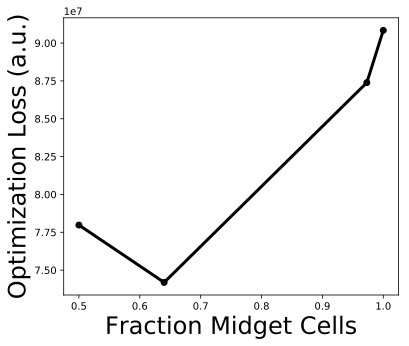

*******************
best result firing rates [8313.123263888889, 8306.426215277777]


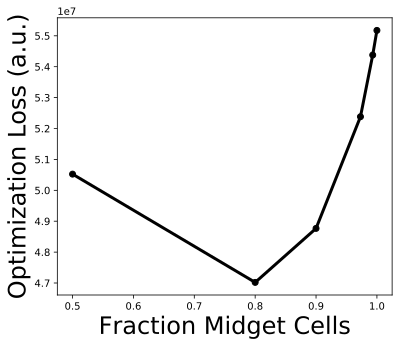

*******************
best result firing rates [2516.0490451388887, 1263.1487630208333, 370.52940538194446, 377.68012152777777]


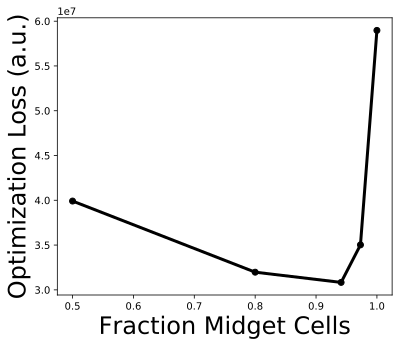

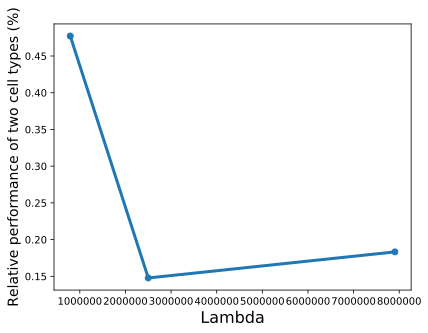

In [697]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
from itertools import combinations_with_replacement

results = np.load('gridsearchresults3DFinalRoundCombined.npy') #XYZWU
print(len(results))
lambdas = [2500000 / np.sqrt(10), 2500000, 2500000*np.sqrt(10)]
lambdas_legend = [round(np.log10(1000000 / lambd) * 2)/2 + 0.5 for lambd in lambdas]
lambdas_legend = [r'$\log(\lambda)$ = '+str(l) + ' + k' for l in lambdas_legend]
benefit = []
for lambd in lambdas:
    resultsCrossSec = []
    for result in results:
        if  'RELU' in result.keys() and result['log_noise'] == -1.0 and np.abs(result['l1_val'] - lambd) < 1 and len(result['VMSE']) >= 10:# and result['Nneurons'][0] + result['Nneurons'][1] in [32, 64, 96, 128, 160]:# and result['Nneurons'][0]==64:# and result['l1_val'] == 500000:
                if len(result['Nneurons']) == 2:
                    resultsCrossSec.append(result)
                elif result['Nneurons'][0] == result['Nneurons'][2] and result['Nneurons'][1] == result['Nneurons'][3]:
                    resultsCrossSec.append(result)
    minLoss = 100000000000000
    minTwoTypeLoss = 1000000000000000000
    twoTypeIndex = -1
    index = -1
    print('*******************')
    ratios = []
    objs = []
    goodones = []
    for i in range(len(resultsCrossSec)):
        result = resultsCrossSec[i]
        loss = result['loss'][9]#result['VMSE'][-1] + result['total_act'] * 1000000 / 2500000
        if result['NTYPE'] == 2:
            if loss < minTwoTypeLoss:
                minTwoTypeLoss = loss
                twoTypeIndex = i
            ratios.append(1.0)
        else:
            ratios.append(result['Nneurons'][1] / (result['Nneurons'][0]+result['Nneurons'][1]))
        objs.append(loss)
        if loss < 1450000:
            goodones.append((result['Nneurons'], result['loss'][-1]))
        if loss < minLoss:
            minLoss = loss
            index = i
    benefit.append(1 - minLoss / minTwoTypeLoss)
    print('best result firing rates', resultsCrossSec[i]['avg_act_cell_type'])
    x_input = np.array(ratios)
    y_input = 100 * (np.array(objs))
    order = (x_input).argsort()
    x_input = x_input[order]
    y_input = y_input[order]
    plt.figure(figsize=(6,5))
    (x_points, y_points) = CalculateEdges(x_input,y_input);
    plt.plot(x_points, y_points, '-o', color='k',  linewidth=3)
    #plt.ylim(np.min(objs), np.min(objs)*2)
#plt.legend(lambdas_legend)
    #plt.yticks([])
    #plt.ylim(np.min(y_points), np.max(y_points))
    plt.ylabel('Optimization Loss (a.u.)', fontsize=24)
    plt.xlabel('Fraction Midget Cells', fontsize=24)
    plt.savefig('OptLoss'+str(lambd)+'.eps',bbox_inches = 'tight', pad_inches = .1)
    plt.show()


plt.plot(lambdas, benefit[::-1], '-o',linewidth = 3)
plt.xlabel('Lambda', fontsize = 16)
plt.ylabel('Relative performance of two cell types (%)', fontsize = 14)
plt.show()

In [592]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

results = np.load('gridsearchresults3DFinalRoundCombined.npy') #XYZWU
print(len(results))
lambd = 2500000 * np.sqrt(10)
resultsCrossSec = []
for result in results:
    if  'RELU' in result.keys() and result['log_noise'] == -1.0 and np.abs(result['l1_val'] - lambd) < 1 and len(result['VMSE']) >= 10:# and result['Nneurons'][0] + result['Nneurons'][1] in [32, 64, 96, 128, 160]:# and result['Nneurons'][0]==64:# and result['l1_val'] == 500000:
        resultsCrossSec.append(result)
minLoss = 100000000000000
index = -1
print('*******************')
ratios = []
objs = []
goodones = []
for i in range(len(resultsCrossSec)):
    result = resultsCrossSec[i]
    loss = result['loss'][9]#result['VMSE'][-1] + result['total_act'] * 1000000 / 2500000
    if result['NTYPE'] == 2:
        ratios.append(1.0)
    else:
        ratios.append(result['Nneurons'][1] / (result['Nneurons'][0]+result['Nneurons'][1]))
    objs.append(loss)
    if loss < 1450000:
        goodones.append((result['Nneurons'], result['loss'][-1]))
    if loss < minLoss:
        minLoss = loss
        index = i
    print(result['Nneurons'], result['loss'], result['avg_act_cell_type'])
x_input = np.array(ratios)
y_input = 100 * (np.array(objs))
order = (x_input).argsort()
x_input = x_input[order]
y_input = y_input[order]

(x_points, y_points) = CalculateEdges(x_input,y_input);

bestResult = resultsCrossSec[5]
print(bestResult['Nneurons'])
W = bestResult['W']



508
*******************
(16, 144, 16, 144) [1562795.8765625, 604454.53984375, 500873.53328125, 454945.015859375, 416701.27203125, 395974.378203125, 377272.599609375, 368459.297734375, 361498.08328125, 353278.319921875] [938.5718994140625, 2555.326171875, 1011.783447265625, 2554.609809027778]
(9, 144, 9, 144) [1645343.68953125, 605647.89890625, 507374.72796875, 456132.688984375, 428166.679609375, 409184.71828125, 394470.8675, 380145.899765625, 374707.36609375, 361630.870234375] [1384.874782986111, 2493.4142795138887, 1126.5879991319443, 2452.5182291666665]
(16, 144, 16, 144) [1704057.07671875, 719716.9403125, 615350.59828125, 561244.2071875, 530316.05734375, 510662.912421875, 494637.532578125, 483424.1425, 475397.271640625, 468882.8453125] [3898.670654296875, 1324.4677734375, 4106.2939453125, 2453.4440104166665]
(9, 144, 9, 144) [1577149.15171875, 628456.460625, 521298.3590625, 471345.069140625, 438622.90296875, 417736.252578125, 396303.033828125, 388717.398984375, 378317.229921875, 369

In [411]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

results = np.load('gridsearchresults3DFinalRoundXYZWU.npy') #XYZWU
print(len(results))
lambd = 2500000
resultsCrossSec = []
for result in results:
    if  'RELU' in result.keys() and  len(result['Nneurons']) == 4 and result['log_noise'] == -1.0 and np.abs(result['l1_val'] - lambd) < 1 and len(result['VMSE']) == 3:# and result['Nneurons'][0] + result['Nneurons'][1] in [32, 64, 96, 128, 160]:# and result['Nneurons'][0]==64:# and result['l1_val'] == 500000:
        if result['Nneurons'][0] != result['Nneurons'][2] or result['Nneurons'][1] != result['Nneurons'][3] or result['Nneurons'] == (36, 144, 36, 144):
            resultsCrossSec.append(result)
minLoss = 100000000000000
index = -1
print('*******************')
ratios = []
objs = []
goodones = []
for i in range(len(resultsCrossSec)):
    result = resultsCrossSec[i]
    print(result['Nneurons'], result['NTYPE'], result['l1_val'], result['total_act'], result['log_noise'], result['MSE'][-1], result['loss'][-1])
    print(result['loss'])
    loss = result['loss'][-1]#result['VMSE'][-1] + result['total_act'] * 1000000 / 2500000
    if result['NTYPE'] == 2:
        ratios.append(1.0)
    else:
        ratios.append(result['Nneurons'][1] / (result['Nneurons'][0]+result['Nneurons'][1]))
    objs.append(loss)
    if loss < 1450000:
        goodones.append((result['Nneurons'], result['loss'][-1]))
    if loss < minLoss:
        minLoss = loss
        index = i
x_input = np.array(ratios)
y_input = 100 * (np.array(objs))
order = (x_input).argsort()
x_input = x_input[order]
y_input = y_input[order]
print('heyy', x_input)

(x_points, y_points) = CalculateEdges(x_input,y_input);

print(index)
bestResult = resultsCrossSec[index]

W = bestResult['W']



434
*******************
(36, 144, 36, 144) 4 2500000 642654.3 -1.0 430735.355078125 730821.39109375
[1979477.3459375, 915093.8025, 730821.39109375]
(37, 144, 35, 144) 4 2500000 744025.6 -1.0 439928.2828125 782785.07046875
[1969573.50375, 957777.28890625, 782785.07046875]
(38, 144, 34, 144) 4 2500000 742075.0 -1.0 477656.22890625 816496.79796875
[2064436.2978125, 1006030.92015625, 816496.79796875]
(39, 144, 33, 144) 4 2500000 688610.4 -1.0 492460.80625 809796.82125
[2009027.25125, 979569.930625, 809796.82125]
(36, 143, 36, 145) 4 2500000 746669.8 -1.0 411865.431484375 751013.70765625
[1944401.45390625, 911238.30046875, 751013.70765625]
(36, 142, 36, 146) 4 2500000 762633.5 -1.0 477292.32125 829559.928125
[2018483.4225, 1005294.3796875, 829559.928125]
(36, 141, 36, 147) 4 2500000 734067.06 -1.0 410477.1003125 743680.54328125
[2048005.8825, 928721.53, 743680.54328125]
(35, 143, 37, 145) 4 2500000 742080.2 -1.0 444192.67703125 785247.0253125
[2037274.7453125, 955181.03796875, 785247.025312

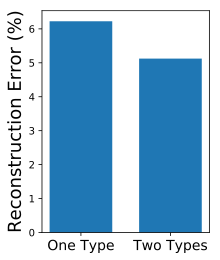

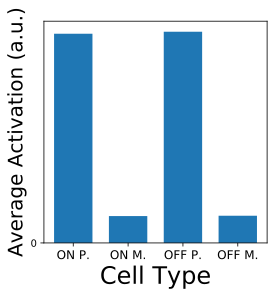

In [696]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('One Type', 'Two Types')
y_pos = np.arange(len(objects))
performance = [100*687668.7975/11049895.665325135, 100*566051.48546875/11049895.665325135]
fig = plt.figure(figsize=(3,4))
plt.bar(y_pos, performance, alpha=1.0, width=0.7)
plt.xticks(y_pos, objects, fontsize=14)
           
#plt.xlabel('Number of Cell Types', fontsize=18)
plt.ylabel('Reconstruction Error (%)', fontsize=18)
plt.show()

activations = [5596.52685546875, 719.615234375, 5650.2373046875, 727.9679361979166]#[4367.535590277777, 446.36659071180554, 4363.730034722223, 487.0804036458333]#[2394.8548177083335, 524.7516276041666, 2438.7000868055557, 482.54893663194446]

fig = plt.figure(figsize=(4,4))

objects = ('ON P.', 'ON M.', 'OFF P.', 'OFF M.')
y_pos = np.arange(len(objects))
plt.bar(y_pos, activations, alpha=1.0, width=0.7)
plt.xticks(y_pos, objects, fontsize=12)
plt.yticks([0])
plt.xlabel('Cell Type', fontsize=24)
plt.ylabel('Average Activation (a.u.)', fontsize=20)
plt.savefig('FiringRates.eps',bbox_inches = 'tight', pad_inches = .1)

plt.show()

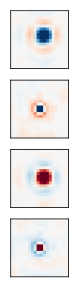

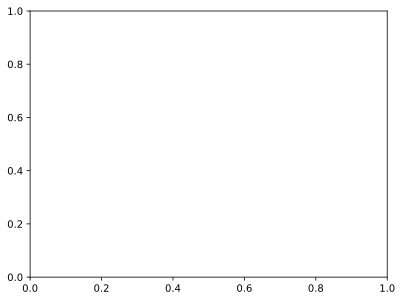

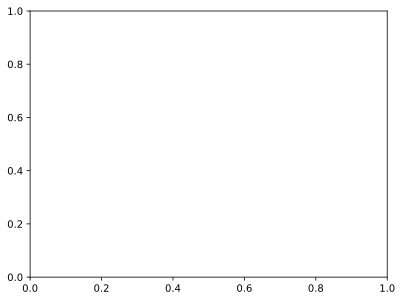

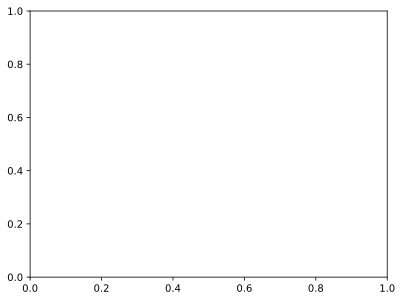

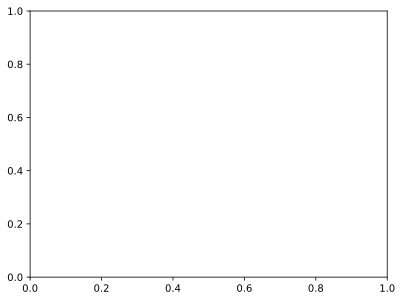

In [705]:

import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

plt.set_cmap('RdBu')

f, axarr = plt.subplots(4, 1)
for ty in range(4):
    for t in range(7, 8):
        spacetime = gaussian_filter(W[:,:,:, :,ty],1.0)
        #plt.figure()
        slice_t = np.squeeze(spacetime[:, :, t, :])
        axarr[ty].imshow(slice_t, vmin=-0.5*np.max(np.abs(gaussian_filter(W[:,:,:, :,ty],1.0))), vmax=0.5*np.max(np.abs(gaussian_filter(W[:,:,:, :,ty],1.0))))
        axarr[ty].set_xticks([])
        axarr[ty].set_yticks([])
        fig, ax = plt.subplots()
f.savefig('PrettyRFs.eps',bbox_inches = 'tight', pad_inches = .1)

plt.show()

        #plt.savefig('test_ty_'+str(ty)+'_t_'+str(t))

(20, 20, 10, 1, 4)
(20, 20, 10, 1, 4)


/home/user/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(20, 20, 10, 1, 4)
(20, 20, 10, 1, 4)


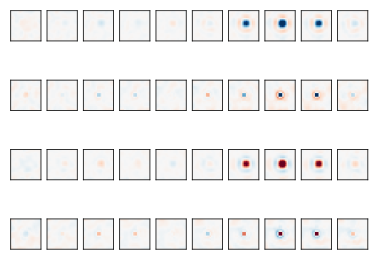

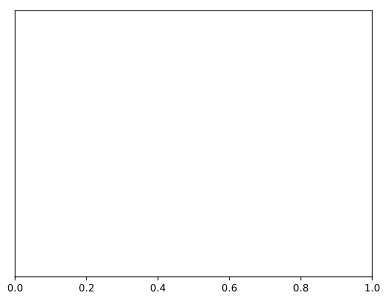

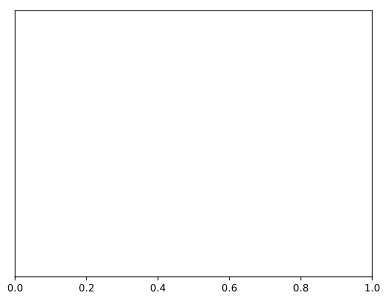

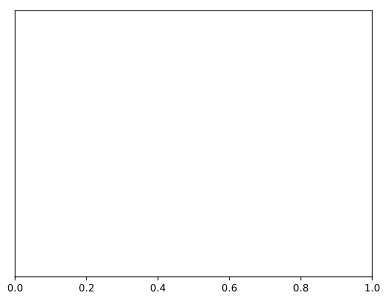

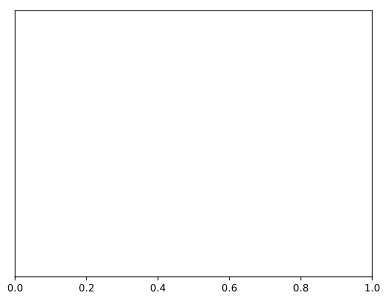

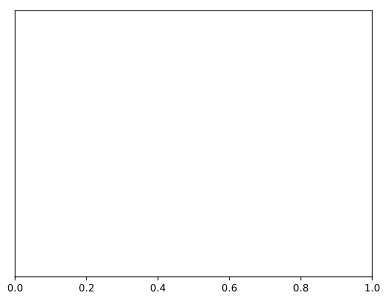

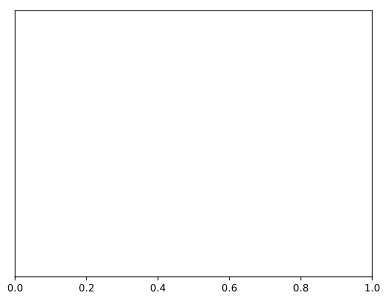

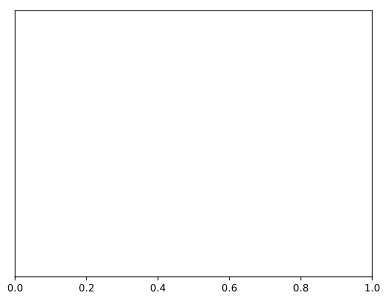

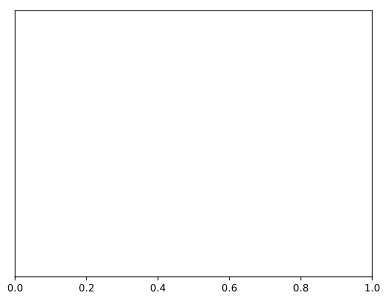

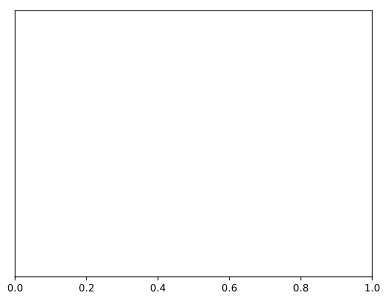

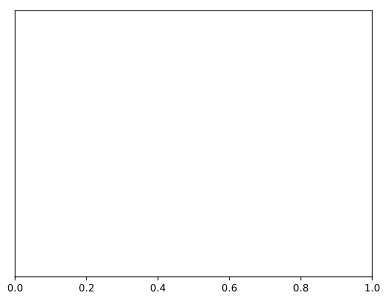

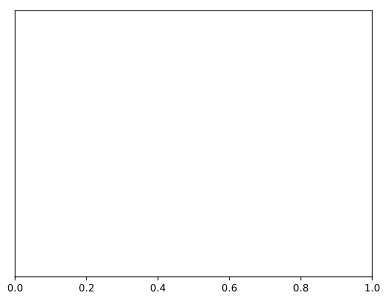

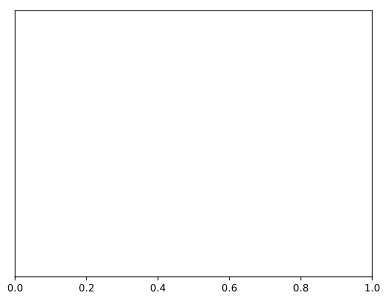

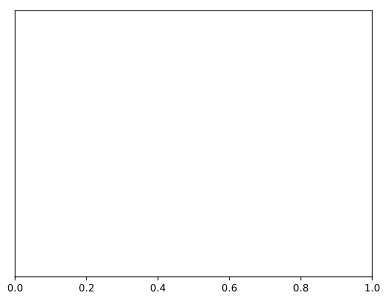

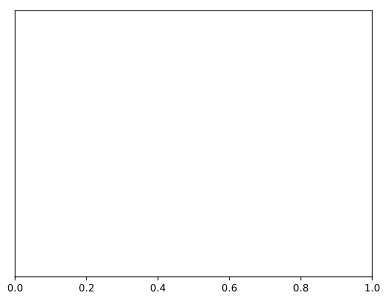

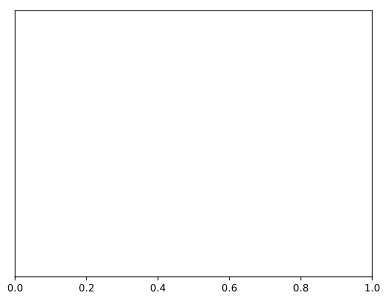

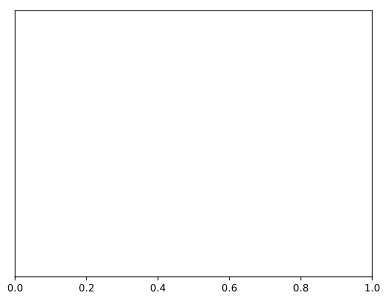

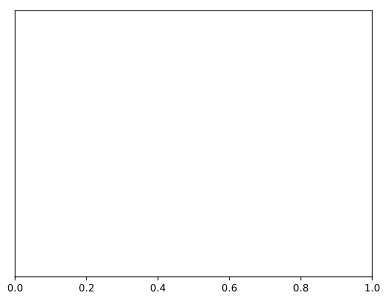

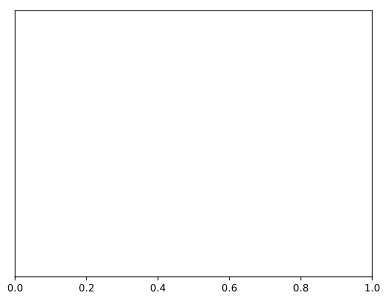

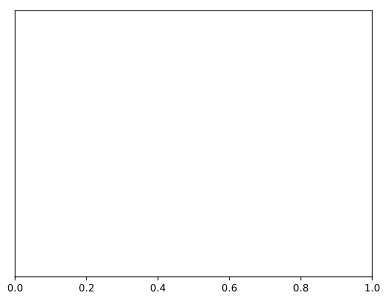

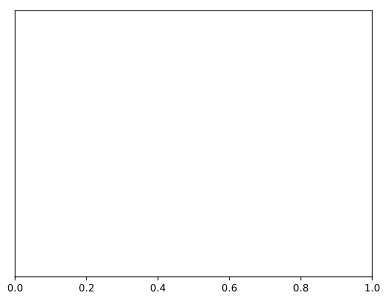

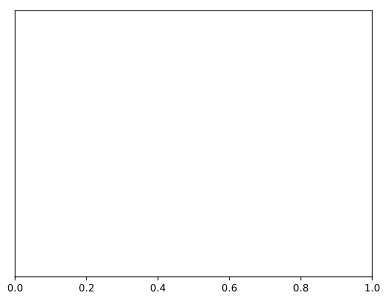

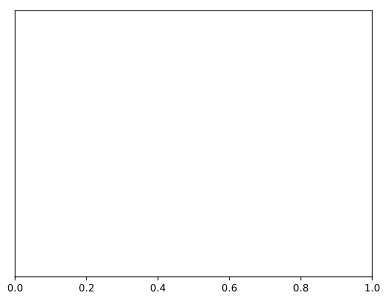

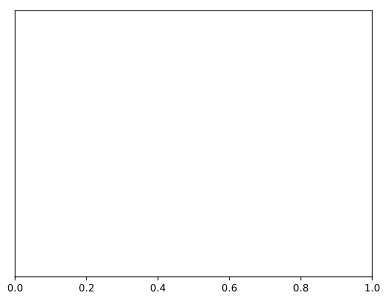

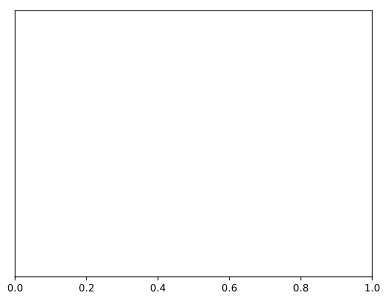

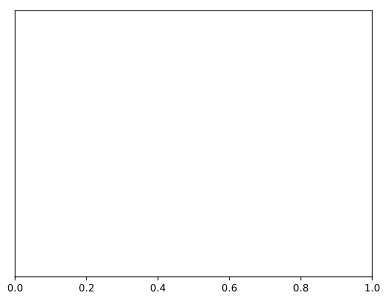

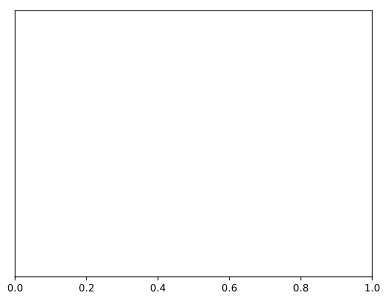

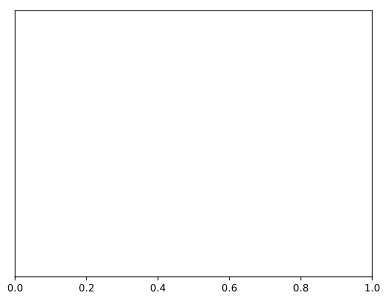

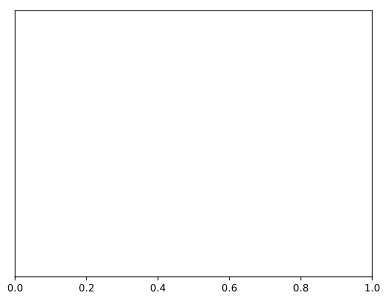

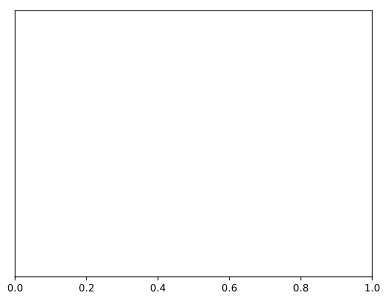

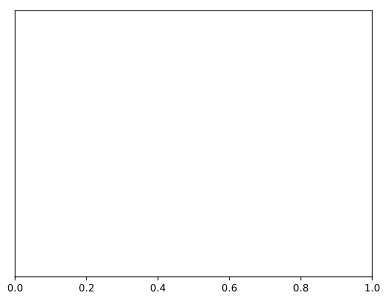

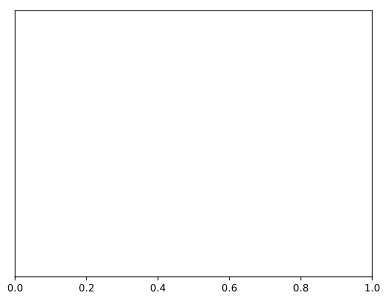

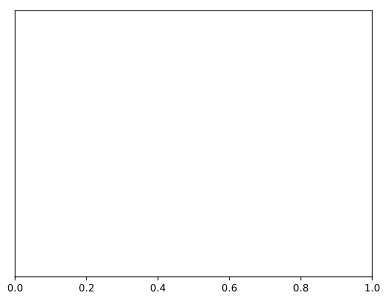

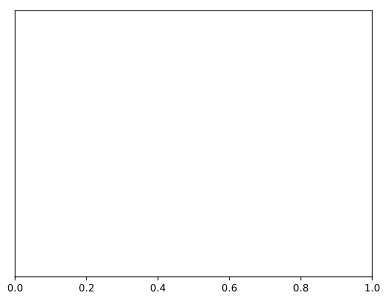

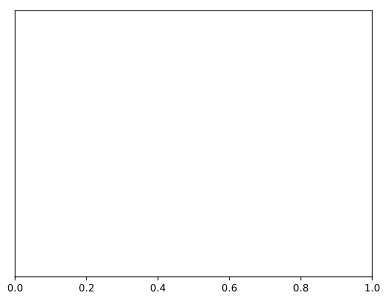

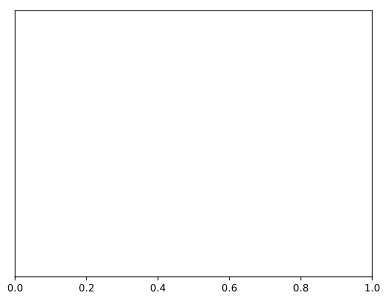

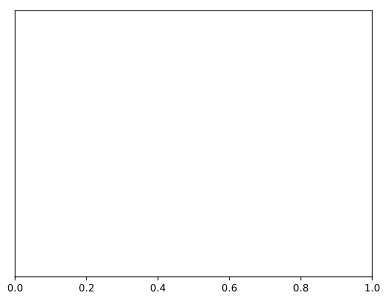

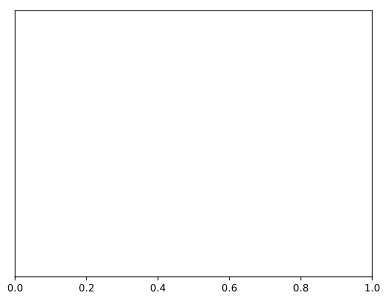

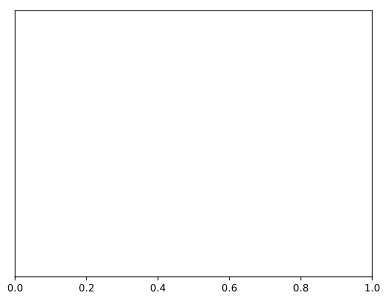

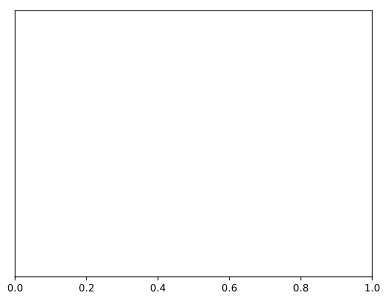

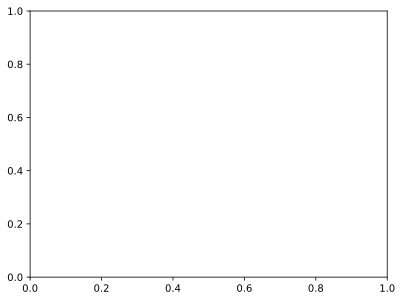

In [715]:

import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

plt.set_cmap('RdBu')

f, axarr = plt.subplots(4, 10)
for ty in range(4):
    print(W.shape)
    for i in range(1):
      for t in range(10):
        thing = gaussian_filter(W[:,:,:, :,ty],1.0)
        #plt.figure()
        ba = np.squeeze(thing[:, :, t, :])
        com = np.argmax(np.abs(thing[:, :, t]))#scipy.ndimage.measurements.center_of_mass(np.abs(thing[:, :, t])) #np.argmax(np.abs(thing[:, :, t]))#
        realcom = scipy.ndimage.measurements.center_of_mass(np.abs(ba))
        #iss,jss = np.unravel_index(com, ba.shape)
        #com = (iss, jss)
        #arst = (int)(realcomsX[ty][7][0])
        #neio = (int)(realcomsX[ty][7][1])
        #ba[arst, neio] = 100000000000
        axarr[ty, t].imshow(ba, vmin=-0.5*np.max(np.abs(gaussian_filter(W[:,:,:, :,ty],1.0))), vmax=0.5*np.max(np.abs(gaussian_filter(W[:,:,:, :,ty],1.0))))

        #plt.colorbar(fig1)
        axarr[ty, t].set_xticks([])
        axarr[ty, t].set_yticks([])
        #axarr[ty, t].plot([com[0]], [com[1]], marker='o', markersize=3, color="purple")
        #axarr[ty, t].plot([realcom[0]], [realcom[1]], marker='o', markersize=3, color="orange")
        #axarr[ty, t].plot([realcomsX[ty][t][0]], [realcomsX[ty][t][1]], marker='o', markersize=3, color="purple")
        #axarr[ty, t].plot([argmaxcomsX[ty][t][0]], [argmaxcomsX[ty][t][1]], marker='o', markersize=3, color="orange")
        #axarr[ty, t].plot([16], [16], marker='o', markersize=3, color="black")


        plt.yticks([])
        fig, ax = plt.subplots()
#plt.clim([-0.5*np.max(np.abs(W)), 0.5*np.max(np.abs(W))])

f.savefig('PrettyRFsFull.eps',bbox_inches = 'tight', pad_inches = .1)

plt.show()

        #plt.savefig('test_ty_'+str(ty)+'_t_'+str(t))

(20, 20, 10, 1, 4)
max 0 0.072523244
max 1 0.07157556
max 2 0.017538877
max 3 0.054052696
max 0 0.072523244


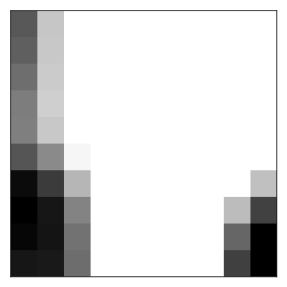

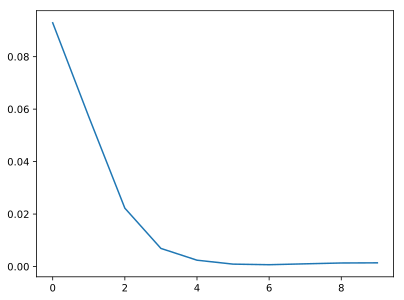

max 1 0.07157556


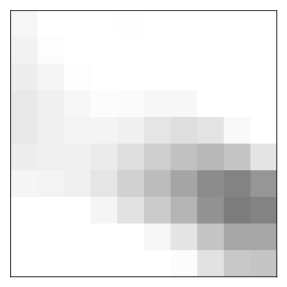

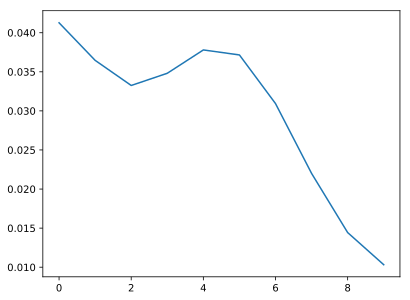

max 2 0.017538877


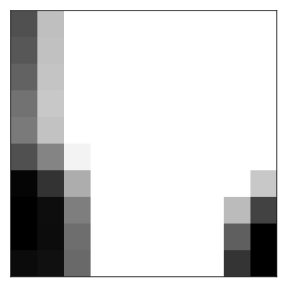

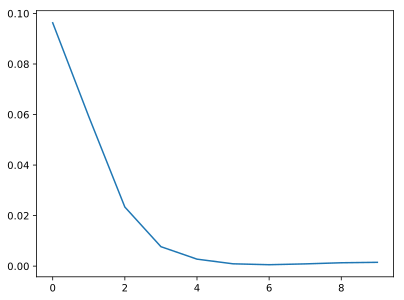

max 3 0.054052696


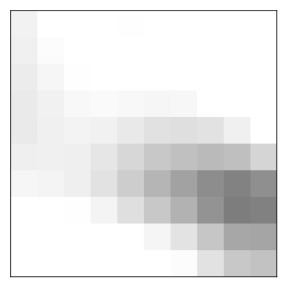

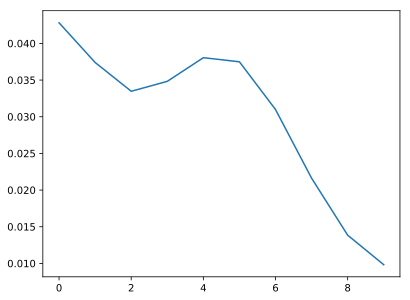

(20, 20, 10, 1, 4)


ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

In [714]:
print(W.shape)

maxi1 = -1e60
maxi2 = -1e60
plt.set_cmap('Greys')

for ty in [0, 1, 2, 3]:
        thing = gaussian_filter(W[:,:,:, :,ty],0.0)
        print('max', ty, np.max(thing))
        ft = (np.abs(np.fft.fftn(np.squeeze(thing))))**2
        ftx = np.transpose((np.mean(ft[:, :, :], axis=0)))[-5:, -10:][:, ::-1]
        ftx = np.repeat(ftx, 2, axis=0)
        fig = plt.figure()
        ftx = gaussian_filter(ftx, 1.0)
        if np.max(ftx) > maxi1:
            maxi1 = np.max(ftx)
        
for i in [1, 3]:
    thing = gaussian_filter(W[:,:,:, :,ty],(0.0, 0.0, 0.0, 0))
    ft = gaussian_filter((np.abs(np.fft.fftn(np.squeeze(thing))))**2, 1.0)
    if np.max(ft) > maxi2:
        maxi2 = np.max(ft)
        
maxi = [maxi1, maxi2, maxi1, maxi2]

for ty in range(4):
    for i in range(1):
      for t in range(1):
        thing = gaussian_filter(W[:,:,:, :,ty],0.0)
        print('max', ty, np.max(thing))
        ft = (np.abs(np.fft.fftn(np.squeeze(thing))))**2
        ftx = np.transpose((np.mean(ft[:, :, :], axis=0)))[-5:, -10:][:, ::-1]
        ftx = np.repeat(ftx, 2, axis=0)
        fig = plt.figure()
        ftx = gaussian_filter(ftx, 1.0)

        im = plt.imshow(ftx, norm=matplotlib.colors.LogNorm(0.2*maxi1, 0.7*maxi1))
        plt.savefig('FourierRFs'+str(ty)+'.eps',bbox_inches = 'tight', pad_inches = .1)

        plt.xticks([])
        plt.yticks([])
        #plt.colorbar(im)
        #plt.clim([0, 1.0*np.max(np.abs(ftx))])
        f, ax = plt.subplots()
        plt.plot(ftx[0])
        plt.show()
        #plt.colorbar()
        #FTs.append(ft)
plt.set_cmap('Greys_r')


print(W.shape)
for ty in range(4):
    for i in range(1):
      for t in range(1):
        thing = gaussian_filter(W[:,:,:, :,ty],(0.0, 0.0, 0.0, 0))
        ft = (np.abs(np.fft.fftn(np.squeeze(thing))))**2
        ftx = np.transpose(np.fft.fftshift(np.max(ft[:, :, :], axis=2)))
        ftx = ftx[ftx.shape[0]//2:, ftx.shape[1]//2:][::-1, :]
        ftx = gaussian_filter(ftx, 1.0)
        fig = plt.figure()
        plt.xticks([])
        plt.yticks([])
        plt.imshow(ftx, norm=matplotlib.colors.LogNorm(0.5, maxi[ty]))
        #plt.clim([0, 1.0*np.max(np.abs(ftx))])

        plt.gca().set_aspect(1.0)
        plt.show()
        

        #plt.savefig('FFTxy_test_ty_'+str(ty))     


/home/user/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


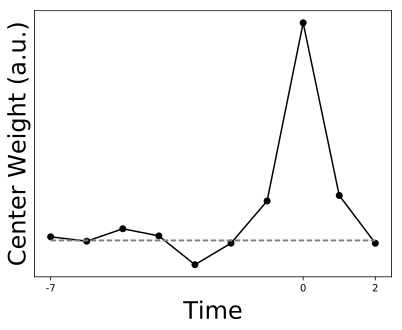

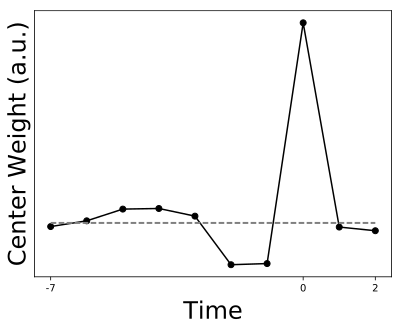

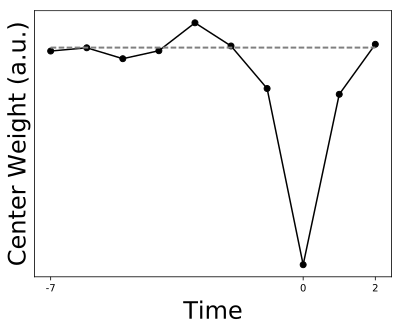

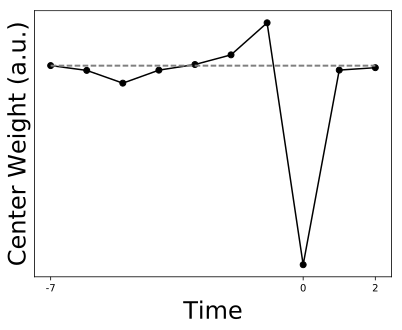

In [711]:
import scipy.ndimage.measurements
import matplotlib.colors
from scipy.interpolate import interp1d
from scipy.interpolate import spline


for ty in range(W.shape[4]):
    argmaxcoms = []
    realcoms = []
    f, axarr = plt.subplots(1, 1)
    spacetime = gaussian_filter(W[:,:,:, 0,ty], 0.0)
    course = np.zeros([W.shape[2]])
    thecom = np.argmax(np.abs(spacetime[:, :, :]))
    iss, jss, kss = np.unravel_index(thecom, spacetime[:, :, :].shape)
    for t in range(W.shape[2]):
        course[t] = (np.sum(spacetime[iss-0:iss+1, jss-0:jss+1, t]))
    course = np.array(course)
    x = np.arange(W.shape[2])
    
    axarr.plot(x, course, 'o-', color='black')
    axarr.plot(x, np.zeros([W.shape[2]]), linestyle='dashed', color='grey', linewidth=2)
    axarr.set_ylabel('Center Weight (a.u.)', fontsize=24, **{'fontname':'Arial'})
    axarr.set_xlabel('Time', labelpad=7, fontsize=24, **{'fontname':'Arial'})
    axarr.set(yticks=[])
    axarr.set(xticks=[0, 7, 9], xticklabels=[-7, 0, 2])
    plt.savefig('TimeRFs'+str(ty)+'.eps',bbox_inches = 'tight', pad_inches = .1)

    plt.show()

